In [1]:
!pip install tensorflow-addons
!pip install wheel
!pip install pandas
!pip install opencv-python
!pip install matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Set seed for reproducibility.
tf.random.set_seed(42)

In [3]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

In [4]:
# Define the input tensor.
input_tensor = tf.random.normal((32, 256, 256, 3))

# Compute involution with stride 1.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2"
)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(input_tensor)
print(
    "with channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape)
)



with stride 1 ouput shape: (32, 256, 256, 3)
with stride 2 ouput shape: (32, 128, 128, 3)
with channel 16 and reduction ratio 2 ouput shape: (32, 256, 256, 3)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
import zipfile
from PIL import Image
from tensorflow.keras.utils import to_categorical

# Define the path to your zip file containing the dataset
zip_file_path = '/content/drive/MyDrive/CSE400 Thesis/Pothole Dataset 10000.zip'

# Define the directory where you want to extract the dataset
extracted_path = '/Downloads/FINAL_DA'

# Create the directory for extracted data
os.makedirs(extracted_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [7]:
train_path = "/Downloads/FINAL_DA/train"
test_path = "/Downloads/FINAL_DA/test"
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(128,128))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(128,128))

        x_test.append(img_arr)

In [8]:

x_train=np.array(x_train)
x_test=np.array(x_test)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 500,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (128, 128),
                                            batch_size = 500,
                                            class_mode = 'sparse')

y_train=training_set.classes
y_test=test_set.classes

num_classes  = 2
input_shape  = (128, 128, 3)

y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:

x_train=np.array(x_train)
x_test=np.array(x_test)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'sparse')

y_train=training_set.classes
y_test=test_set.classes

num_classes  = 2
input_shape  = (128, 128, 3)

y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
!pip install -U -q tensorflow-addons
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

In [11]:
num_classes  = 2
input_shape  = (128, 128, 3)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8000, 128, 128, 3) - y_train shape: (8000, 2)
x_test shape: (2000, 128, 128, 3) - y_test shape: (2000, 2)


In [12]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8000, 128, 128, 3)
y_train shape: (8000, 2)
8000 train samples
2000 test samples


In [14]:
inputs = keras.Input(shape=(128, 128, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(2)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")



inv_model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


inv_hist = inv_model.fit(x_train, y_train,
              batch_size=32,
              epochs=100,
              validation_data=(x_test, y_test),
              shuffle=True)


loss, accuracy = inv_model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/100
250/250 [==============================] - 9s 19ms/step - loss: 0.6073 - accuracy: 0.6591 - val_loss: 0.8021 - val_accuracy: 0.5040
Epoch 2/100
250/250 [==============================] - 4s 16ms/step - loss: 0.5009 - accuracy: 0.7582 - val_loss: 0.4788 - val_accuracy: 0.7665
Epoch 3/100
250/250 [==============================] - 4s 17ms/step - loss: 0.4470 - accuracy: 0.7844 - val_loss: 0.4639 - val_accuracy: 0.7745
Epoch 4/100
250/250 [==============================] - 5s 19ms/step - loss: 0.3906 - accuracy: 0.8121 - val_loss: 0.4206 - val_accuracy: 0.8000
Epoch 5/100
250/250 [==============================] - 4s 16ms/step - loss: 0.3213 - accuracy: 0.8503 - val_loss: 0.4863 - val_accuracy: 0.7760
Epoch 6/100
250/250 [==============================] - 4s 17ms/step - loss: 0.2770 - accuracy: 0.8744 - val_loss: 0.4099 - val_accuracy: 0.8515
Epoch 7/100
250/250 [==============================] - 5s 19ms/step - loss: 0.2222 - accuracy: 0.9044 - val_loss: 0.4253 - val_accuracy:

In [15]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


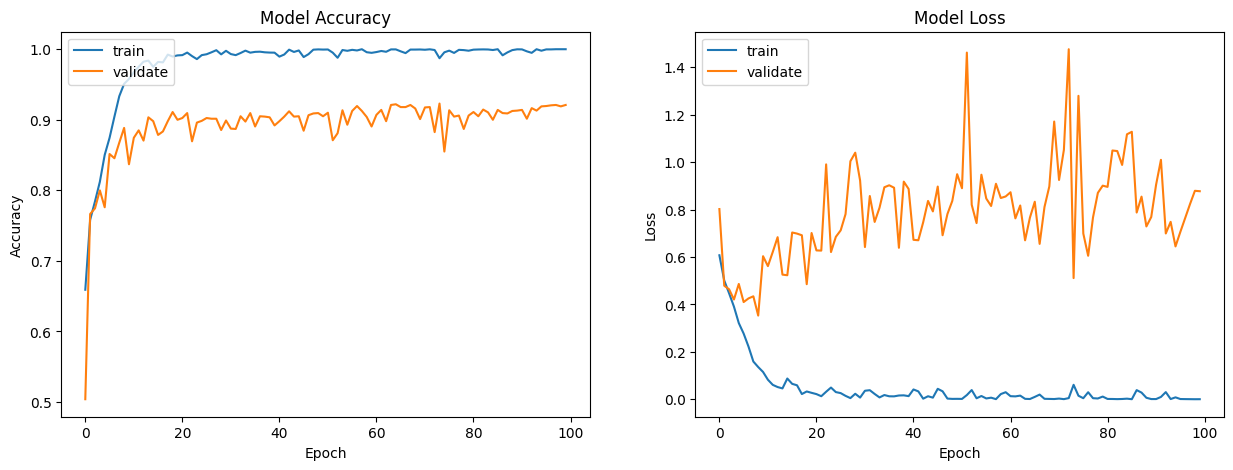

In [16]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(inv_hist.history['accuracy'])                   #Change History Variable
    axs[0].plot(inv_hist.history['val_accuracy'])               #Change History Variable
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(inv_hist.history['loss'])                       #Change History Variable
    axs[1].plot(inv_hist.history['val_loss'])                   #Change History Variable
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

print(inv_hist.history.keys())                                  #Change History Variable

plotmodelhistory(inv_hist)                                      #Change History Variable

In [17]:
# No change

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="black" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

63/63 [==============================] - 0s 6ms/step


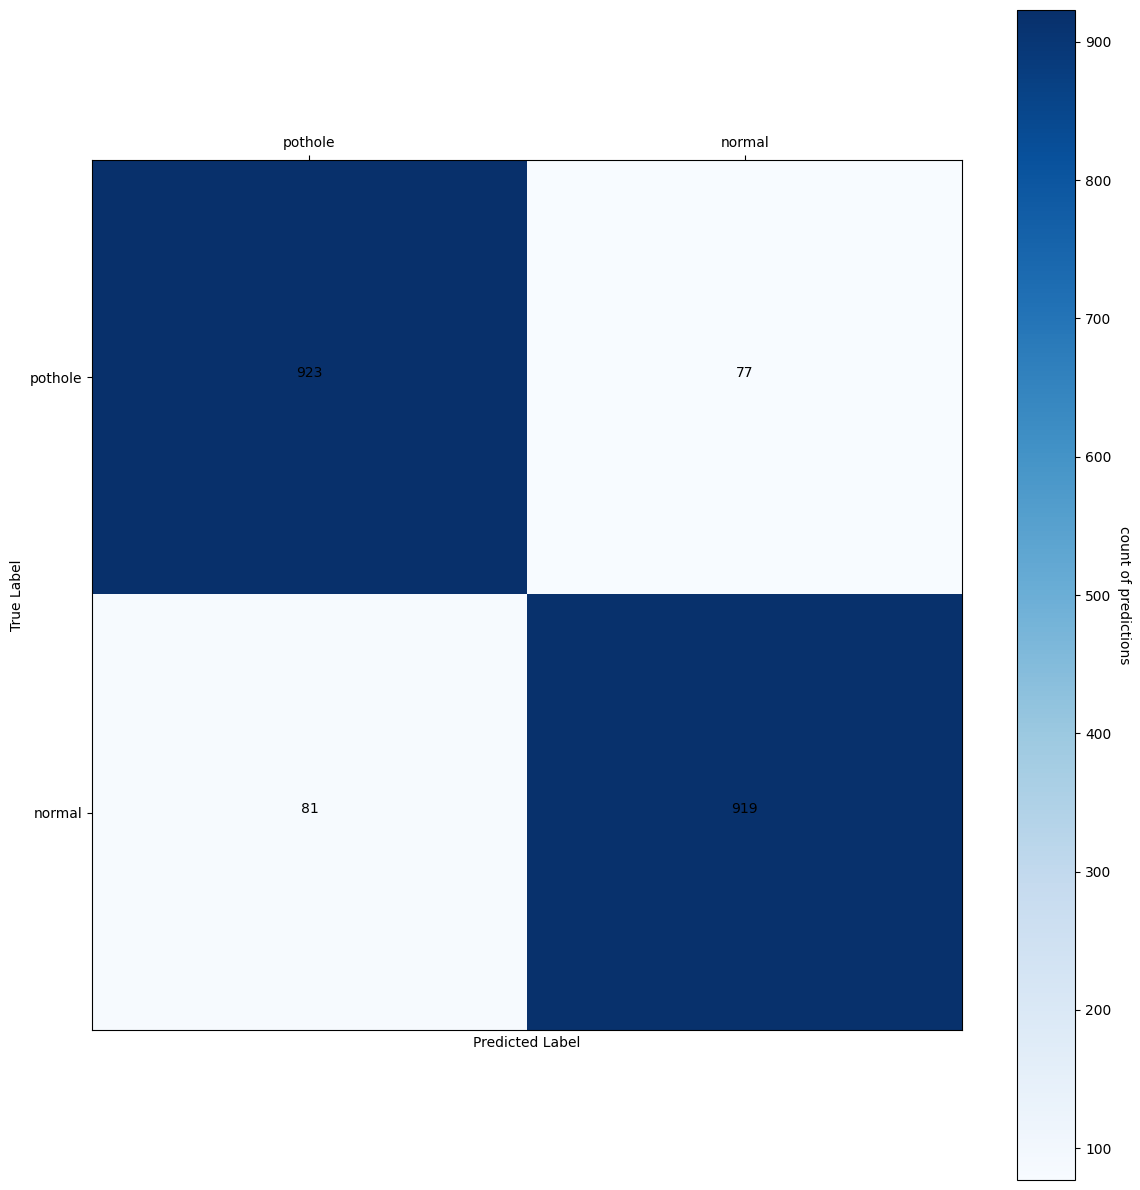

In [21]:
labels = ['pothole', 'normal']

pred = inv_model.predict(x_test)                                       #Change Model Name


# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [22]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



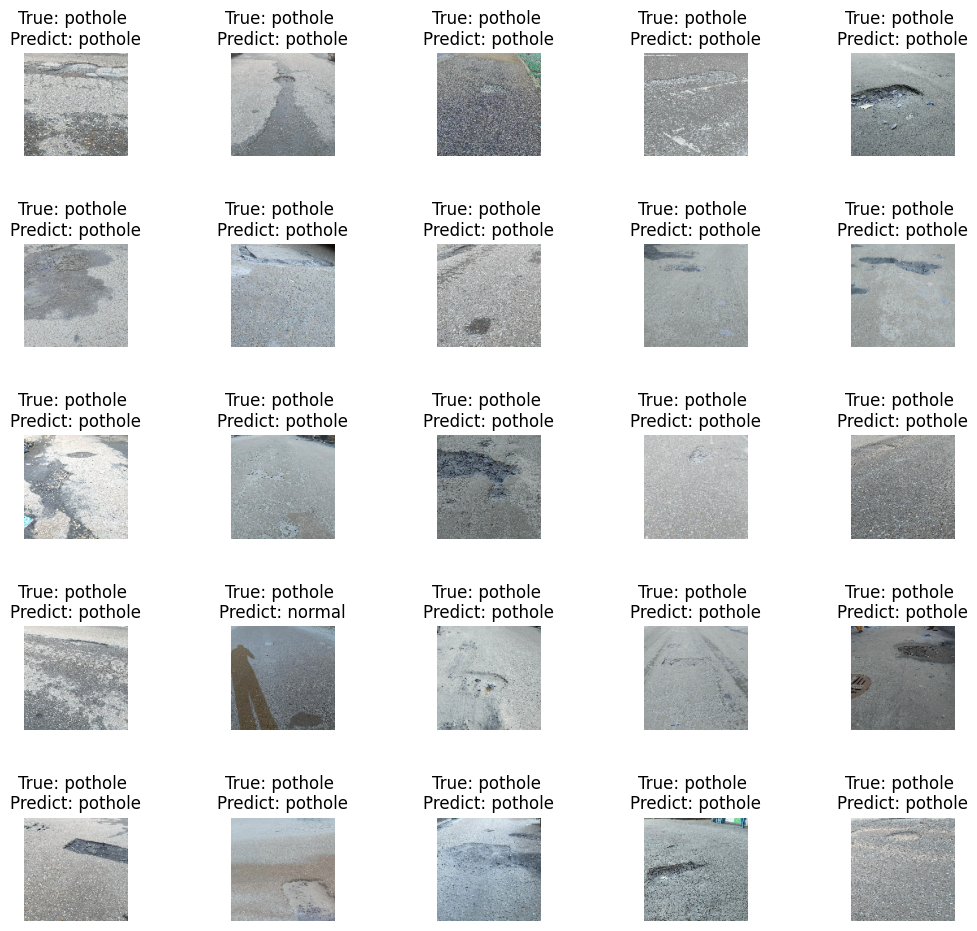

In [23]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

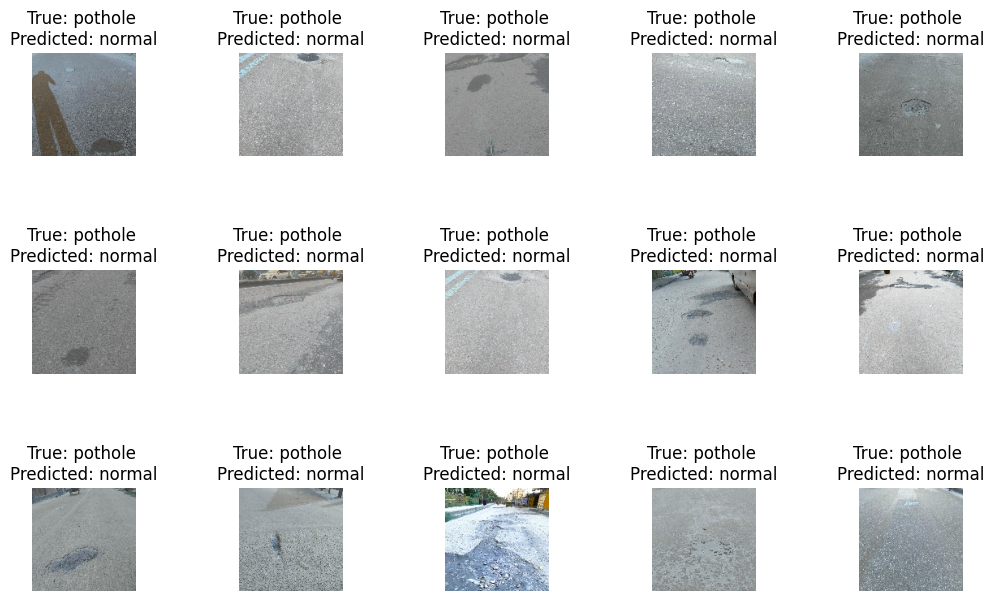

In [24]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]],
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)